In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [6]:
df_gs = pd.read_hdf( DATA_DIR + "df_gs.hdf", "a/" )
df_gs1 = df_gs[ df_gs.eval_cnt < 300 ]
df_gs = df_gs1.to_hdf( DATA_DIR + "df_gs1.hdf", "a/" )
del df_gs1

In [3]:
#DATA_DIR=r"C:/Users/Mateo/Documents/_TRABAJO\Yuxi\Hyper_par_opt/"
DATA_DIR = r"C:\_DATA\experimentation\HC_Default_Risk/"

def read_ds( fname, max_evals = 300, invert_fun_val=False ) :  
    df0 = pd.read_hdf( DATA_DIR + fname, "a/" )
    df0 = df0[df0['eval_cnt'] < max_evals ]
    if invert_fun_val :
        df0['fun_val'] = -df0['fun_val']
    df0['best_so_far'] = df0.groupby( 'trial' )["fun_val"].apply( lambda x : x.cummax() )
    
    df0.set_index( 'trial', inplace=True )
    df0.sort_index( inplace=True )
    
    return df0

In [7]:
df_gs = read_ds( "df_gs1.hdf" )
df_cd =  read_ds( "df_cd.hdf", invert_fun_val=True)
df_gen = read_ds( "df_gen_10.hdf" )

In [8]:
df_gs.shape

(3000000, 4)

In [45]:
#df1 = df0[df0['trial'] == 5]
def plot_1_trial( df0, algo, ax, i = 5, max_evals=100, ylim=(0.70, 0.745), ylabel='')  :
    sns.scatterplot( data=df0.loc[i], x='eval_cnt', y='fun_val', label= 'all fun. values', ax=ax)
    sns.lineplot( data=df0.loc[i], x='eval_cnt', y='best_so_far', color='orange', label='running best', ax=ax)    
    ax.set_title( algo ) 
    ax.set_xlim( (0,max_evals) ) 
    ax.set_ylim( ylim  ) 
    ax.set_ylabel( ylabel ) 
    ax.set_xlabel( 'CV_AUC evaluation #' ) 
#sns.legend( ['fun_val', 'best_so_far']) 

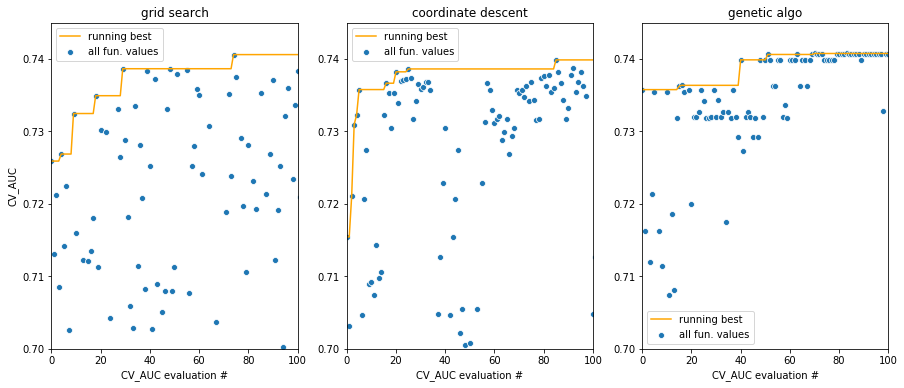

In [46]:
fig, axes = plt.subplots( 1, 3, figsize=(15,6))
plot_1_trial( df_gs, 'grid search', ax=axes[0], i=3, ylabel='CV_AUC')
plot_1_trial( df_cd, 'coordinate descent', ax=axes[1])
plot_1_trial( df_gen, 'genetic algo', ax=axes[2], i=3)


In [47]:
def plot_many_bests( df0, n_trials, ax=None, start_idx=0,  algo=None, xlim=(1,100), ylim=(0.70, 0.745), ylabel='' ) :
    for i in range( start_idx, start_idx  + n_trials ) : 
        plt = sns.lineplot( data= df0.loc[i], x='eval_cnt', y='best_so_far', color='orange', ax=ax )
        #print( id(plt) )

    plt.axes.set_title( f'{algo}') 

    plt.axes.set_xlim( xlim )
    plt.axes.set_ylim( ylim )
    plt.axes.set_ylabel( ylabel )
    plt.axes.set_xlabel( "CV_AUC evaluation #" )

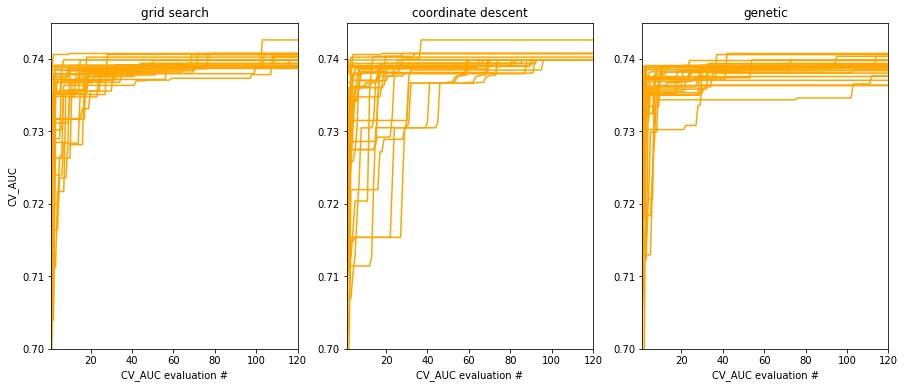

In [48]:
fig, axes = plt.subplots( 1, 3, figsize=(15,6))
xlim=(1,120)
plot_many_bests( df_gs,  30, start_idx=20, algo= 'grid search',        ax=axes[0], ylabel='CV_AUC', xlim=xlim)
plot_many_bests( df_cd,  30, start_idx=20, algo= 'coordinate descent', ax=axes[1], xlim=xlim)
plot_many_bests( df_gen, 30, start_idx=20, algo= 'genetic',            ax=axes[2], xlim=xlim)

In [70]:
def compute_percentiles( grp ) :
    pct005 = grp["best_so_far"].quantile(0.005)
    pct01 = grp["best_so_far"].quantile(0.01)
    pct05 = grp["best_so_far"].quantile(0.05)
    pct10 = grp["best_so_far"].quantile(0.10)
    pct50 = grp["best_so_far"].quantile(0.50)
    pct70 = grp["best_so_far"].quantile(0.70)
    pct90 = grp["best_so_far"].quantile(0.90)
    pct95 = grp["best_so_far"].quantile(0.95)
    max_  = grp["best_so_far"].max()
    
    return pd.Series(        [ pct005,   pct01,   pct05,   pct10,   pct50 ,  pct70,   pct90,   pct95, ], 
                      index=[ "pct005", "pct01", "pct05", "pct10", "pct50", "pct70", "pct90","pct95" 
                            ] ) 

In [71]:
pct_gs, pct_cd, pct_gen  = [ df.groupby( "eval_cnt" ).apply( compute_percentiles ).reset_index() 
                             for df in [df_gs, df_cd, df_gen] ] 

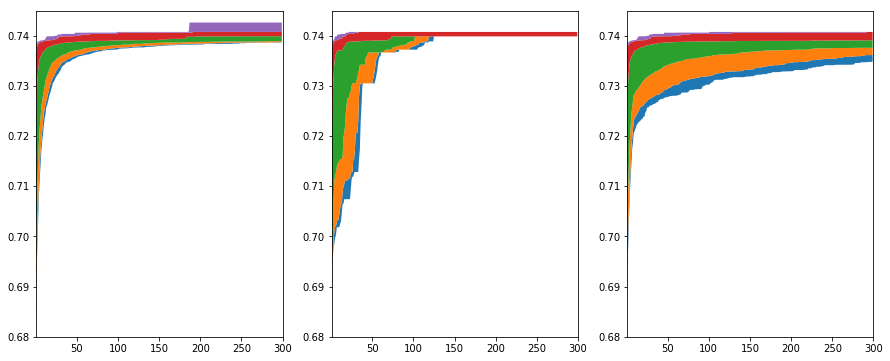

In [21]:
fig, axes = plt.subplots( 1, 3, figsize=(15,6))

def plot_percentiles( pct_df,  ax, xlim, ylim) :
    x=pct_df['eval_cnt']
    #ax.set_title( algo )
    ax.fill_between( x, pct_df['pct005'], y2=pct_df['pct01'] )
    ax.fill_between( x, pct_df['pct01'] , y2=pct_df['pct05'] )
    ax.fill_between( x, pct_df['pct05'] , y2=pct_df['pct50'] )
    ax.fill_between( x, pct_df['pct50'] , y2=pct_df['pct90'] )
    ax.fill_between( x, pct_df['pct90'] , y2=pct_df['pct95'] )
    ax.set_xlim( xlim )
    ax.set_ylim( ylim )
    
xlim=(1,300)    
ylim=(0.68, 0.745) 
plot_percentiles( pct_gs,  ax=axes[0], xlim=xlim, ylim=ylim )
plot_percentiles( pct_cd,  ax=axes[1], xlim=xlim, ylim=ylim )
plot_percentiles( pct_gen, ax=axes[2], xlim=xlim, ylim=ylim )

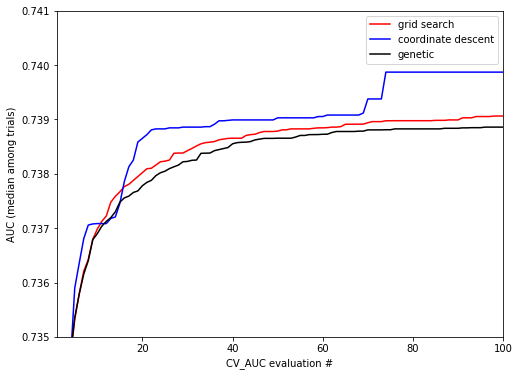

In [67]:
def gen_pct_plot( pct="pct50", ylabel="AUC (median among trials)", ylim=(0.735,0.741), xlim=(1, 100 ) ) :
    n = list( range( len(pct_gs) ) ) 
    plt.figure( figsize=(8,6) ) 
    plt.plot( n, pct_gs[ pct], 'r-', 
              n, pct_cd[ pct ], 'b-', 
              n, pct_gen[pct], 'k-' ) 
    ax = plt.gca()
    ax.set_ylim( ylim )
    ax.set_xlim( xlim )
    ax.set_ylabel( ylabel )
    ax.set_xlabel( "CV_AUC evaluation #" )
    ax.legend( ['grid search','coordinate descent','genetic'])
    
gen_pct_plot( pct="pct50", ylabel="AUC (median among trials)" ) 

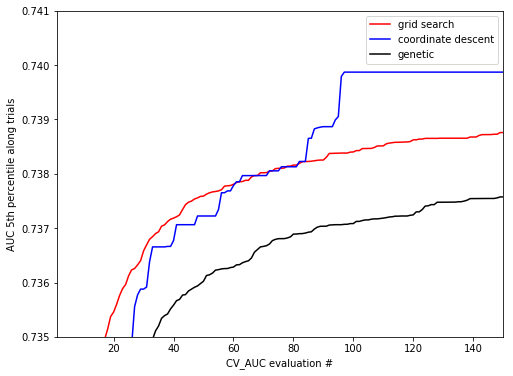

In [68]:
    
gen_pct_plot( pct="pct05", ylabel="AUC 5th percentile along trials", xlim=(1,150) ) 

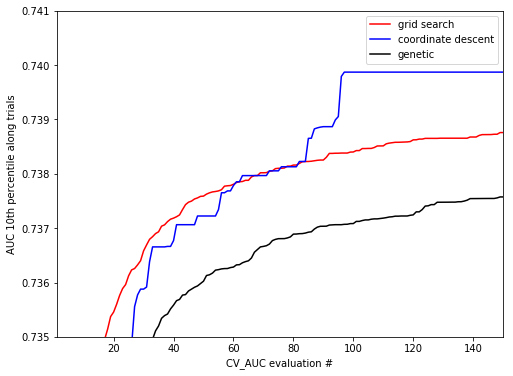

In [72]:
    
gen_pct_plot( pct="pct10", ylabel="AUC 10th percentile along trials", xlim=(1,150) ) 

ValueError: x and y must have same first dimension, but have shapes (100,) and (300,)

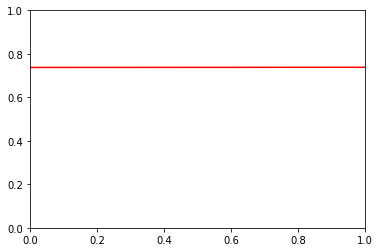

In [239]:
n = list( range( len(pct_gs) ) ) 
plt.plot( n, pct_gs['pct95'], 'r-', 
          n, pct_cd['pct95'], 'b-', 
          n, pct_gen['pct95'], 'k-') 

(0.7, 0.745)

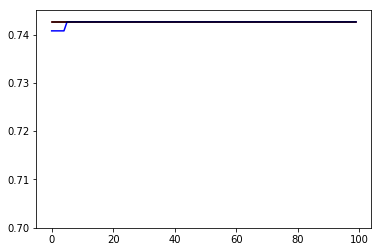

In [215]:
n = list( range( len(pct_gs) ) ) 
plt.plot( n, pct_gs['max'], 'r-', 
          n, pct_cd['max'], 'b-', 
          n, pct_gen['max'], 'k-' )
plt.gca().set_ylim( (0.70,0.745) )